## Deja Brew
Introduction to Data Science (MATH 4100 / CS 5963), University of Utah

#### Final Project 
Ja-Rey Corcuera U1156525@utah.edu
Brianna Mendoza U1189033@utah.edu


## Background and Motivation
As college students, it seems that coffee has become a necessary fuel for many of us, worldwide. Though coffee may serve this purpose for students on a college campus, coffee can be more than that. What we hope to explore with this data is whether coffee has other significant characteristics, other than just caffeination. Can we explore its features such as acidity level, roast, place of origin, etc. to create a different relationship and experience with coffee? Do these things make a difference in the cup you drink? As people who drink coffee regularly, can there be more to it?

The goal of this data search is just to provide the people who drink coffee with more information. There is no ground-breaking, hidden information in this data, rather it is all information that we may already inherantly know just by experiencing coffee, but that we can now categorize into specific qualities that we enjoy the most. As a result, this data will allow the user to identify where they can find the perfect cup that has the most of what they love. 
We hope that what this data does the most is enhance the coffee-drinking experience of all who have access to it.

## Project Objectives
The core objectives of this project is quantify the many qualitative characteristics of coffee and thoroughly understand what they mean in a numerical sense. We want to identifying the important characteristics of coffee from around the world and understand the correlations, if there are any, between each one. Would we be able to recommend a coffee to a user based on desired characteristics, price, or origin? Can the agtron score predict the overall rating of the brew? What taste profiles do the highest rated coffees have, and is there a trend? Where does most coffee come from? Where does it go?
All of the questions can provide a more in depth understanding of each brew. Whether its amroma thats important to the drinker, or merely price, there may be a lot that results in the perfect poor. 

Coffee drinking, to most, is just a leisure activity, or a necessary start to their morning. This project can broaden a person’s knowledge of the beverage and heighten their experiences with it as a delicacy, not just as an energy booster.

## Background

**State-of-the-art: you could describe briefly other techniques that have been applied to your dataset or similar (but not exact) datasets; you could also talk about examples/applications where the same or similar data analysis techniques you choose in your project have been applied.** 

## Data
The data for this project was obtained from The Coffee Review website (https://www.coffeereview.com/review/?locations=na), where a group of coffee connoiseurs have taken the time since 1997 to thoroughly examine coffee from all over the world. We scraped this site for over 3000 reviews of coffee ground here in the United States.

While the data that we are working with comes from just the reviews, we also read the information on the rest of the website concerning how each coffee is rated, ethical considereations of how the coffee is sourced, and other endeavors The Coffee Review is a part of, to help better undertand their motive for creating this site and rating each coffee

Here's an example of one review from the website:
<img src="review.png" width="550">


## Ethical Considerations

TODO Preface: we don’t know how this coffee was sourced - but we assume it was ethical

## Data Processing

In [51]:
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import re
import random
import seaborn as sns
import statsmodels.formula.api as sm
import ssl
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import geopandas as gpd
import geoplot
import warnings
warnings.filterwarnings('ignore')

### Webscraping

In [ ]:
page_count = 286 # number of pages to scrape from (each page has 20 reviews)
coffee_df = pd.DataFrame()
counter = 0

# Loop through each webpage of reviews
for page in range(1, page_count):

    url = "https://www.coffeereview.com/review/page/" + str(page) +  "/?locations=na"
    print("Opening page URL:", url)

    ssl._create_default_https_context = ssl._create_unverified_context
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urlopen(req).read()

    soup = BeautifulSoup(html, 'html.parser')

    time.sleep(random.uniform(0.25, 0.75)) # Random delay between accessing pages
    
    # Loop through all reviews in the current webpage and find attributes
    for curr_review in soup.find_all(class_="review-template"):

        review_url = curr_review.find_all('a', href=True)[1]['href']
        #print("Opening review URL:", review_url)

        review_req = Request(review_url, headers={'User-Agent': 'Mozilla/5.0'})
        review_html = urlopen(review_req).read()

        review_soup = BeautifulSoup(review_html, 'html.parser')

        time.sleep(random.uniform(0.1, 0.3)) # Random delay between accessing reviews

        attributes = {}

        roaster = curr_review.find("p", class_="review-roaster").get_text()
        attributes["Roaster"] = roaster

        name = review_soup.find("h1", class_="review-title").get_text()
        attributes["Name"] = name

        rating = review_soup.find('span', class_="review-template-rating").get_text()
        attributes["Rating"] = rating

        i = 1
        curr_attribute = ""
        for tag in review_soup.find_all(class_="review-template-table")[0].find_all('td'):
            if i % 2 == 1:
                curr_attribute = tag.get_text()[:-1]
            else:
                attributes[curr_attribute] = tag.get_text()
            i = i + 1

        i = 1
        curr_attribute = ""
        for tag in review_soup.find_all(class_="review-template-table")[1].find_all('td'):
            if i % 2 == 1:
                curr_attribute = tag.get_text()[:-1]
            else:
                value = re.sub('\s+', '', tag.get_text())
                attributes[curr_attribute] = value
            i = i + 1 

        # Append all attributes of this review to the dataframe
        coffee_df = coffee_df.append(attributes, ignore_index=True)

        counter = counter + 1
    
print("Writing dataframe to csv file")
coffee_df.to_csv('coffeereview.csv', index=False)
coffee_df

Here We have scraped all of the data from the website. We use beautiful soup to sift through the HTML, identifying which tags contain the relevant information.  

### Data Cleanup & Wrangling

In [202]:
# Read dataframe from csv file
coffee_df =  pd.read_csv("coffeereview.csv")

# Extract both agtron readings from agtron attribute
coffee_df[["Agtron Ext", "Agtron Gnd"]] = coffee_df["Agtron"].str.split("/", expand=True)

# Drop reviews that don't record agtron values
coffee_df = coffee_df.drop(coffee_df[coffee_df.Agtron == "NA/NA"].index)

# Drop reviews that don't record origin location
#coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"] == "Not disclosed."].index)
coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"].str.contains("Not disclosed") == True].index)

# Drop reviews that don't record external agtron values
coffee_df = coffee_df.drop(coffee_df[coffee_df["Agtron Ext"] == ""].index)

# Drop unnecessary attributes
coffee_df = coffee_df.drop(columns = ["With Milk", "Acidity", "Acidity/Structure", "Agtron"])

# Drop all reviews with missing information
coffee_df = coffee_df.dropna()

# Filter out reviews that use non-US dollars
coffee_df = coffee_df[coffee_df["Est. Price"].str[0] == "$"]

# Filter out reviews that don't use ounces
coffee_df = coffee_df[(coffee_df["Est. Price"].str.contains("ounce") == True) | (coffee_df["Est. Price"].str.contains("oz") == True)]

# Filter out all other unordinary reviews
coffee_df = coffee_df[(coffee_df["Est. Price"].str.contains("CAD") == False) & (coffee_df["Est. Price"].str.contains("pounds") == False) & (coffee_df["Est. Price"].str.contains("online") == False) & (coffee_df["Est. Price"].str.contains("NTD") == False) & (coffee_df["Est. Price"].str.contains("g") == False) & (coffee_df["Est. Price"].str.contains("grams") == False)]

# Calculate dollars per ounce from estimated price
dollarsperoz_arr = []
for arr in coffee_df["Est. Price"].str.split("/"):
    dollarsperoz = float(arr[0].split("$")[1]) / float(arr[1].strip().split(" ")[0])
    dollarsperoz_arr.append(round(dollarsperoz, 2))

# Insert dollars per ounce column into datafame
coffee_df.insert(7, "DollarsPerOz", dollarsperoz_arr)

# Add a column that represents roast level as a numerical variable
coffee_df["Roast_Level_num"] = coffee_df["Roast Level"].map({'Light':0, 'Medium-Light': 1, 'Medium': 2, 'Medium-Dark': 3, 'Dark': 4, 'Very Dark': 4})

# Parse columns to appropriate data types
change_type = {
    'Rating': int,
    'DollarsPerOz': float,
    'Aroma': int,
    'Body': int,
    'Flavor': int,
    'Aftertaste': int,   
    "Agtron Ext": int,
    "Agtron Gnd": int,
    "Roast_Level_num": int
     }

coffee_df = coffee_df.astype(change_type).reset_index(drop=True)
coffee_df

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,DollarsPerOz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num
0,Paradise Roasters,Colombia Finca La Primavera Sidra,96,"Minneapolis, Minnesota","Huila, Colombia",Light,$48.00/12 ounces,4.00,March2022,9,9,10,9,64,82,0
1,SkyTop Coffee,Ethiopia Anaerobic Shantawene,94,"Manlius, New York","Sidamo (also Sidama) growing region, south-cen...",Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,58,80,1
2,Jaunt Coffee Roasters,Ethiopia Bensa Asefa Qonqana,94,"San Diego, California","Sidamo (also Sidama) growing region, south-cen...",Light,$26.00/12 ounces,2.17,March2022,9,9,9,8,64,86,0
3,Magnolia Coffee,Ethiopia Durato Bombe,94,"Charlotte, North Carolina","Bombe mountains, Sidama Region, southern Ethiopia",Medium-Light,$19.00/12 ounces,1.58,March2022,9,9,9,8,58,78,1
4,SkyTop Coffee,Ethiopia Washed Shantawene,94,"Manlius, New York","Sidamo (also Sidama) growing region, south-cen...",Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,60,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,Moonstruck Farm,100% Kona Estate Grade,91,"Captain Cook, Hawaii","Kona growing district, ""Big Island"" of Hawaii.",Medium-Light,$25 / 16 oz.,1.56,March2010,8,8,9,8,51,84,1
3006,Paradise Roasters,Hawaii Laka,92,"Ramsey, Minnesota","Ka'u growing district, southwestern corner of ...",Light,$25 / 12 oz.,2.08,March2010,9,8,9,8,66,99,0
3007,Rusty's Hawaiian Coffee,100% Ka’u Classic,92,"Pahala, Hawaii","Ka'u growing district, southwestern corner of ...",Light,$30 / 16 oz.,1.88,March2010,9,8,9,8,52,90,0
3008,Coffea Roasterie,Dominican Republic Las Lagunas,92,"Sioux Falls, South Dakota",Dominican Republic,Medium-Light,$14.25 / 12 oz.,1.19,March2010,9,8,9,8,54,71,1


Here the data is cleaned: columns are added and dropped. There were a few reviews that did not contain all the information that we needed from them, so they were dropped. For example, some reviews did not contain agtron levels or places of origin, so they were dropped. We understand that dropping these does limit, in some sense, the story we are able to tell about each roast, but there were so little dropped in comparison to the rest of the reviews, that it would not affect the bigger picture. 


From each review, there were some attributes in the ratings that we did not feel were relevant, or that didn't show up often enought to take into account, things like how the coffee tasted with milk, or the acidity structure. This seemed less likely to impact the overall review of each roast.


In order to keep the data at bay, we restricted our data set to only roasts that were sold in U.S. dollars, as to make other calculations easy and to make the data easier to understand. After reducing to only the roasts sold in the U.S., each price was normalized to price per ounce. Using this data, we can see the average price each ounce of coffee is and calculate a general value with its price and rating. This will allow us to identify which coffees have the highest rating for the lowest prices. This may be important to a consumer. 


We also converted the roast level to integer representations to be able to numerically integrate them into other regressioins, plots, etc. Each roast level was assigned a number between 0 and 4, light being 0, and dark being 4. 


Lastly, we ensured that all the necessary values were converted to floats so that they would be usable throughout the project. 

In [203]:
# Filter out reviews where coffee origin location is unknown
countries_df =  pd.read_csv("world.csv")
countries = countries_df["en"].values

count = 0
for origin in coffee_df["Coffee Origin"].str.split(","):
    count = count + 1
    found = False
    for name in origin:
        for country in countries:
            if country.lower() in name.lower():
                found = True
                coffee_df.loc[count-1, "Coffee Origin"]=country
                break
                
        if found == True:
            break

    if found == False:
        coffee_df.loc[count-1, "Coffee Origin"]="NA"

coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"]== "NA"].index).reset_index(drop=True)

In [52]:
# Add lat/long coords of origin country 
coffee_df["Latitude"] = ""
coffee_df["Longitude"] = ""
latlong_df =  pd.read_csv("latlongcountries.csv")
countries = latlong_df["Country"]

count = 0
for origin in coffee_df["Coffee Origin"]:
    count = count + 1
    found = False

    for country in countries:
        if country.lower() == origin.lower():
            lat = latlong_df[latlong_df.Country == country].Latitude.values[0]
            long = latlong_df[latlong_df.Country == country].Longitude.values[0]

            coffee_df.loc[count-1, "Latitude"]=lat
            coffee_df.loc[count-1, "Longitude"]=long

            found = True
            break
            
    if found == False:
            coffee_df.loc[count-1, "Latitude"]=0
            coffee_df.loc[count-1, "Longitude"]=0

In order to effectively portray our categorical data, the place of origin, we were able to find a csv file with the latititude and longitude of every country in the world, and wer were able to map these locations to places of origin of each of the coffee. The data is merely loaded here but is used effectively further down in the project. 

In [205]:
# Filter out reviews where roaster location is unknown or not in the U.S.
states_df =  pd.read_csv("states.csv")
states = states_df["State"].values

count = 0
for location in coffee_df["Roaster Location"].str.split(","):
    count = count + 1
    found = False
    for name in location:
        for state in states:
            if state.lower() in name.lower():
                found = True

                coffee_df.loc[count-1, "Roaster Location"]=state
                break
                
        if found == True:
            break

    if found == False:
        coffee_df.loc[count-1, "Roaster Location"]="NA"

coffee_df = coffee_df.drop(coffee_df[coffee_df["Roaster Location"]== "NA"].index).reset_index(drop=True)
coffee_df = coffee_df.drop(coffee_df[coffee_df["Agtron Ext"] > 200].index)

If location was not available in any given review, that review was dropped. 

In [206]:
# Calculate value column
coffee_df["Value"] = (coffee_df["Rating"] - coffee_df["Rating"].min()) / coffee_df["DollarsPerOz"]

To calculate a general value of each of the roasts, the rating of coffee was divided by the dollar value per ounce to obtain an overall value of each coffee. This can provide the consumer with a single value to observe if the details are not as important, but it also provided us with another parameter to evaluate. 

In [207]:
# Write cleaned dataframe to csv
coffee_df.to_csv('coffeereview_cleaned.csv', index=False)
coffee_df

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,DollarsPerOz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num,Latitude,Longitude,Value
0,Paradise Roasters,Colombia Finca La Primavera Sidra,96,Minnesota,Colombia,Light,$48.00/12 ounces,4.00,March2022,9,9,10,9,64,82,0,4.0,-72.0,5.250000
1,SkyTop Coffee,Ethiopia Anaerobic Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,58,80,1,8.0,38.0,11.377246
2,Jaunt Coffee Roasters,Ethiopia Bensa Asefa Qonqana,94,California,Ethiopia,Light,$26.00/12 ounces,2.17,March2022,9,9,9,8,64,86,0,8.0,38.0,8.755760
3,Magnolia Coffee,Ethiopia Durato Bombe,94,North Carolina,Ethiopia,Medium-Light,$19.00/12 ounces,1.58,March2022,9,9,9,8,58,78,1,8.0,38.0,12.025316
4,SkyTop Coffee,Ethiopia Washed Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,60,78,1,8.0,38.0,11.377246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,Hula Daddy,Kona Fancy Natural,91,Hawai,Hawaii,Light,$79.95 / 16 oz.,5.00,March2010,8,8,9,8,59,94,0,19.8968,-155.5828,3.200000
2898,Moonstruck Farm,100% Kona Estate Grade,91,Hawai,Hawaii,Medium-Light,$25 / 16 oz.,1.56,March2010,8,8,9,8,51,84,1,19.8968,-155.5828,10.256410
2899,Paradise Roasters,Hawaii Laka,92,Minnesota,Hawaii,Light,$25 / 12 oz.,2.08,March2010,9,8,9,8,66,99,0,19.8968,-155.5828,8.173077
2900,Rusty's Hawaiian Coffee,100% Ka’u Classic,92,Hawai,Hawaii,Light,$30 / 16 oz.,1.88,March2010,9,8,9,8,52,90,0,19.8968,-155.5828,9.042553


### Exploratory Analysis

We begin our analysis here. Creating a data frame of the cleaned csv, we are able to both numerically and visusally represent our data. We are able to see what columns are in our data frame, we can see the numerical correlation between each of the paramters, we can load a visusal representation of each correlation through a heat map, and we can see how each parameter relates to the other through a pair plot. 
We can see individual relationships between each paramter, along with a general, big-picture relation overall. 

In [53]:
coffee_df = pd.read_csv("coffeereview_cleaned.csv")
coffee_df

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,DollarsPerOz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num,Latitude,Longitude,Value
0,Paradise Roasters,Colombia Finca La Primavera Sidra,96,Minnesota,Colombia,Light,$48.00/12 ounces,4.00,March2022,9,9,10,9,64,82,0,4.0000,-72.0000,5.250000
1,SkyTop Coffee,Ethiopia Anaerobic Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,58,80,1,8.0000,38.0000,11.377246
2,Jaunt Coffee Roasters,Ethiopia Bensa Asefa Qonqana,94,California,Ethiopia,Light,$26.00/12 ounces,2.17,March2022,9,9,9,8,64,86,0,8.0000,38.0000,8.755760
3,Magnolia Coffee,Ethiopia Durato Bombe,94,North Carolina,Ethiopia,Medium-Light,$19.00/12 ounces,1.58,March2022,9,9,9,8,58,78,1,8.0000,38.0000,12.025316
4,SkyTop Coffee,Ethiopia Washed Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,60,78,1,8.0000,38.0000,11.377246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,Hula Daddy,Kona Fancy Natural,91,Hawai,Hawaii,Light,$79.95 / 16 oz.,5.00,March2010,8,8,9,8,59,94,0,19.8968,-155.5828,3.200000
2895,Moonstruck Farm,100% Kona Estate Grade,91,Hawai,Hawaii,Medium-Light,$25 / 16 oz.,1.56,March2010,8,8,9,8,51,84,1,19.8968,-155.5828,10.256410
2896,Paradise Roasters,Hawaii Laka,92,Minnesota,Hawaii,Light,$25 / 12 oz.,2.08,March2010,9,8,9,8,66,99,0,19.8968,-155.5828,8.173077
2897,Rusty's Hawaiian Coffee,100% Ka’u Classic,92,Hawai,Hawaii,Light,$30 / 16 oz.,1.88,March2010,9,8,9,8,52,90,0,19.8968,-155.5828,9.042553


In [209]:
coffee_df.corr()

,Rating,DollarsPerOz,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num,Latitude,Longitude,Value
Rating,1.000000,0.329556,0.701026,0.603004,0.771296,0.667192,0.437326,0.430982,-0.404929,0.035314,0.037572,-0.186081
DollarsPerOz,0.329556,1.000000,0.229038,0.235352,0.237736,0.211672,0.154040,0.178103,-0.170785,0.186688,-0.241745,-0.682543
Aroma,0.701026,0.229038,1.000000,0.293367,0.514443,0.277910,0.315289,0.310378,-0.294733,0.040481,0.041328,-0.133116
Body,0.603004,0.235352,0.293367,1.000000,0.337392,0.214117,0.275279,0.309542,-0.278889,0.038294,-0.006037,-0.189075
Flavor,0.771296,0.237736,0.514443,0.337392,1.000000,0.432015,0.371765,0.332696,-0.316592,0.026619,0.049468,-0.103890
Aftertaste,0.667192,0.211672,0.277910,0.214117,0.432015,1.000000,0.267624,0.245049,-0.229990,0.003494,0.011000,-0.075546
Agtron Ext,0.437326,0.154040,0.315289,0.275279,0.371765,0.267624,1.000000,0.814959,-0.852307,0.087356,-0.062527,-0.190959
Agtron Gnd,0.430982,0.178103,0.310378,0.309542,0.332696,0.245049,0.814959,1.000000,-0.901188,0.081215,-0.049707,-0.231243
Roast_Level_num,-0.404929,-0.170785,-0.294733,-0.278889,-0.316592,-0.229990,-0.852307,-0.901188,1.000000,-0.078030,0.050103,0.222490
Latitude,0.035314,0.186688,0.040481,0.038294,0.026619,0.003494,0.087356,0.081215,-0.078030,1.000000,-0.458813,-0.273426


Running the correlations for each parameter lets us know which characteristics have relationships. We can see that roast level and agtron grade after its ground have a strong negative correlation. This imples that a longer roast has a relationshop with the color of the bean. Longer roasting results in a darker bean. The less time it is spent roasting, the lighter the bean. This is definitely common sense, but we can see that the data supports this. But let us examine another correlation that maybe isn't so straight forward. The correlation between Aroma and rating is fairly strong and positive. This tells us that the higher the aroma, the higher the rating. Why could this be?

<AxesSubplot:>

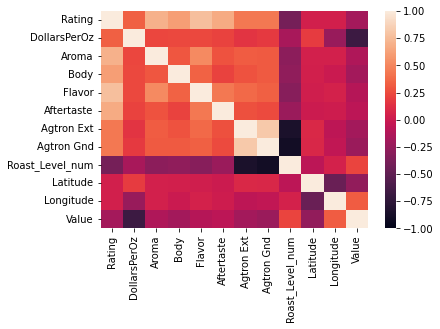

In [214]:
sns.heatmap(data = coffee_df.corr(), vmin = -1, vmax = 1)

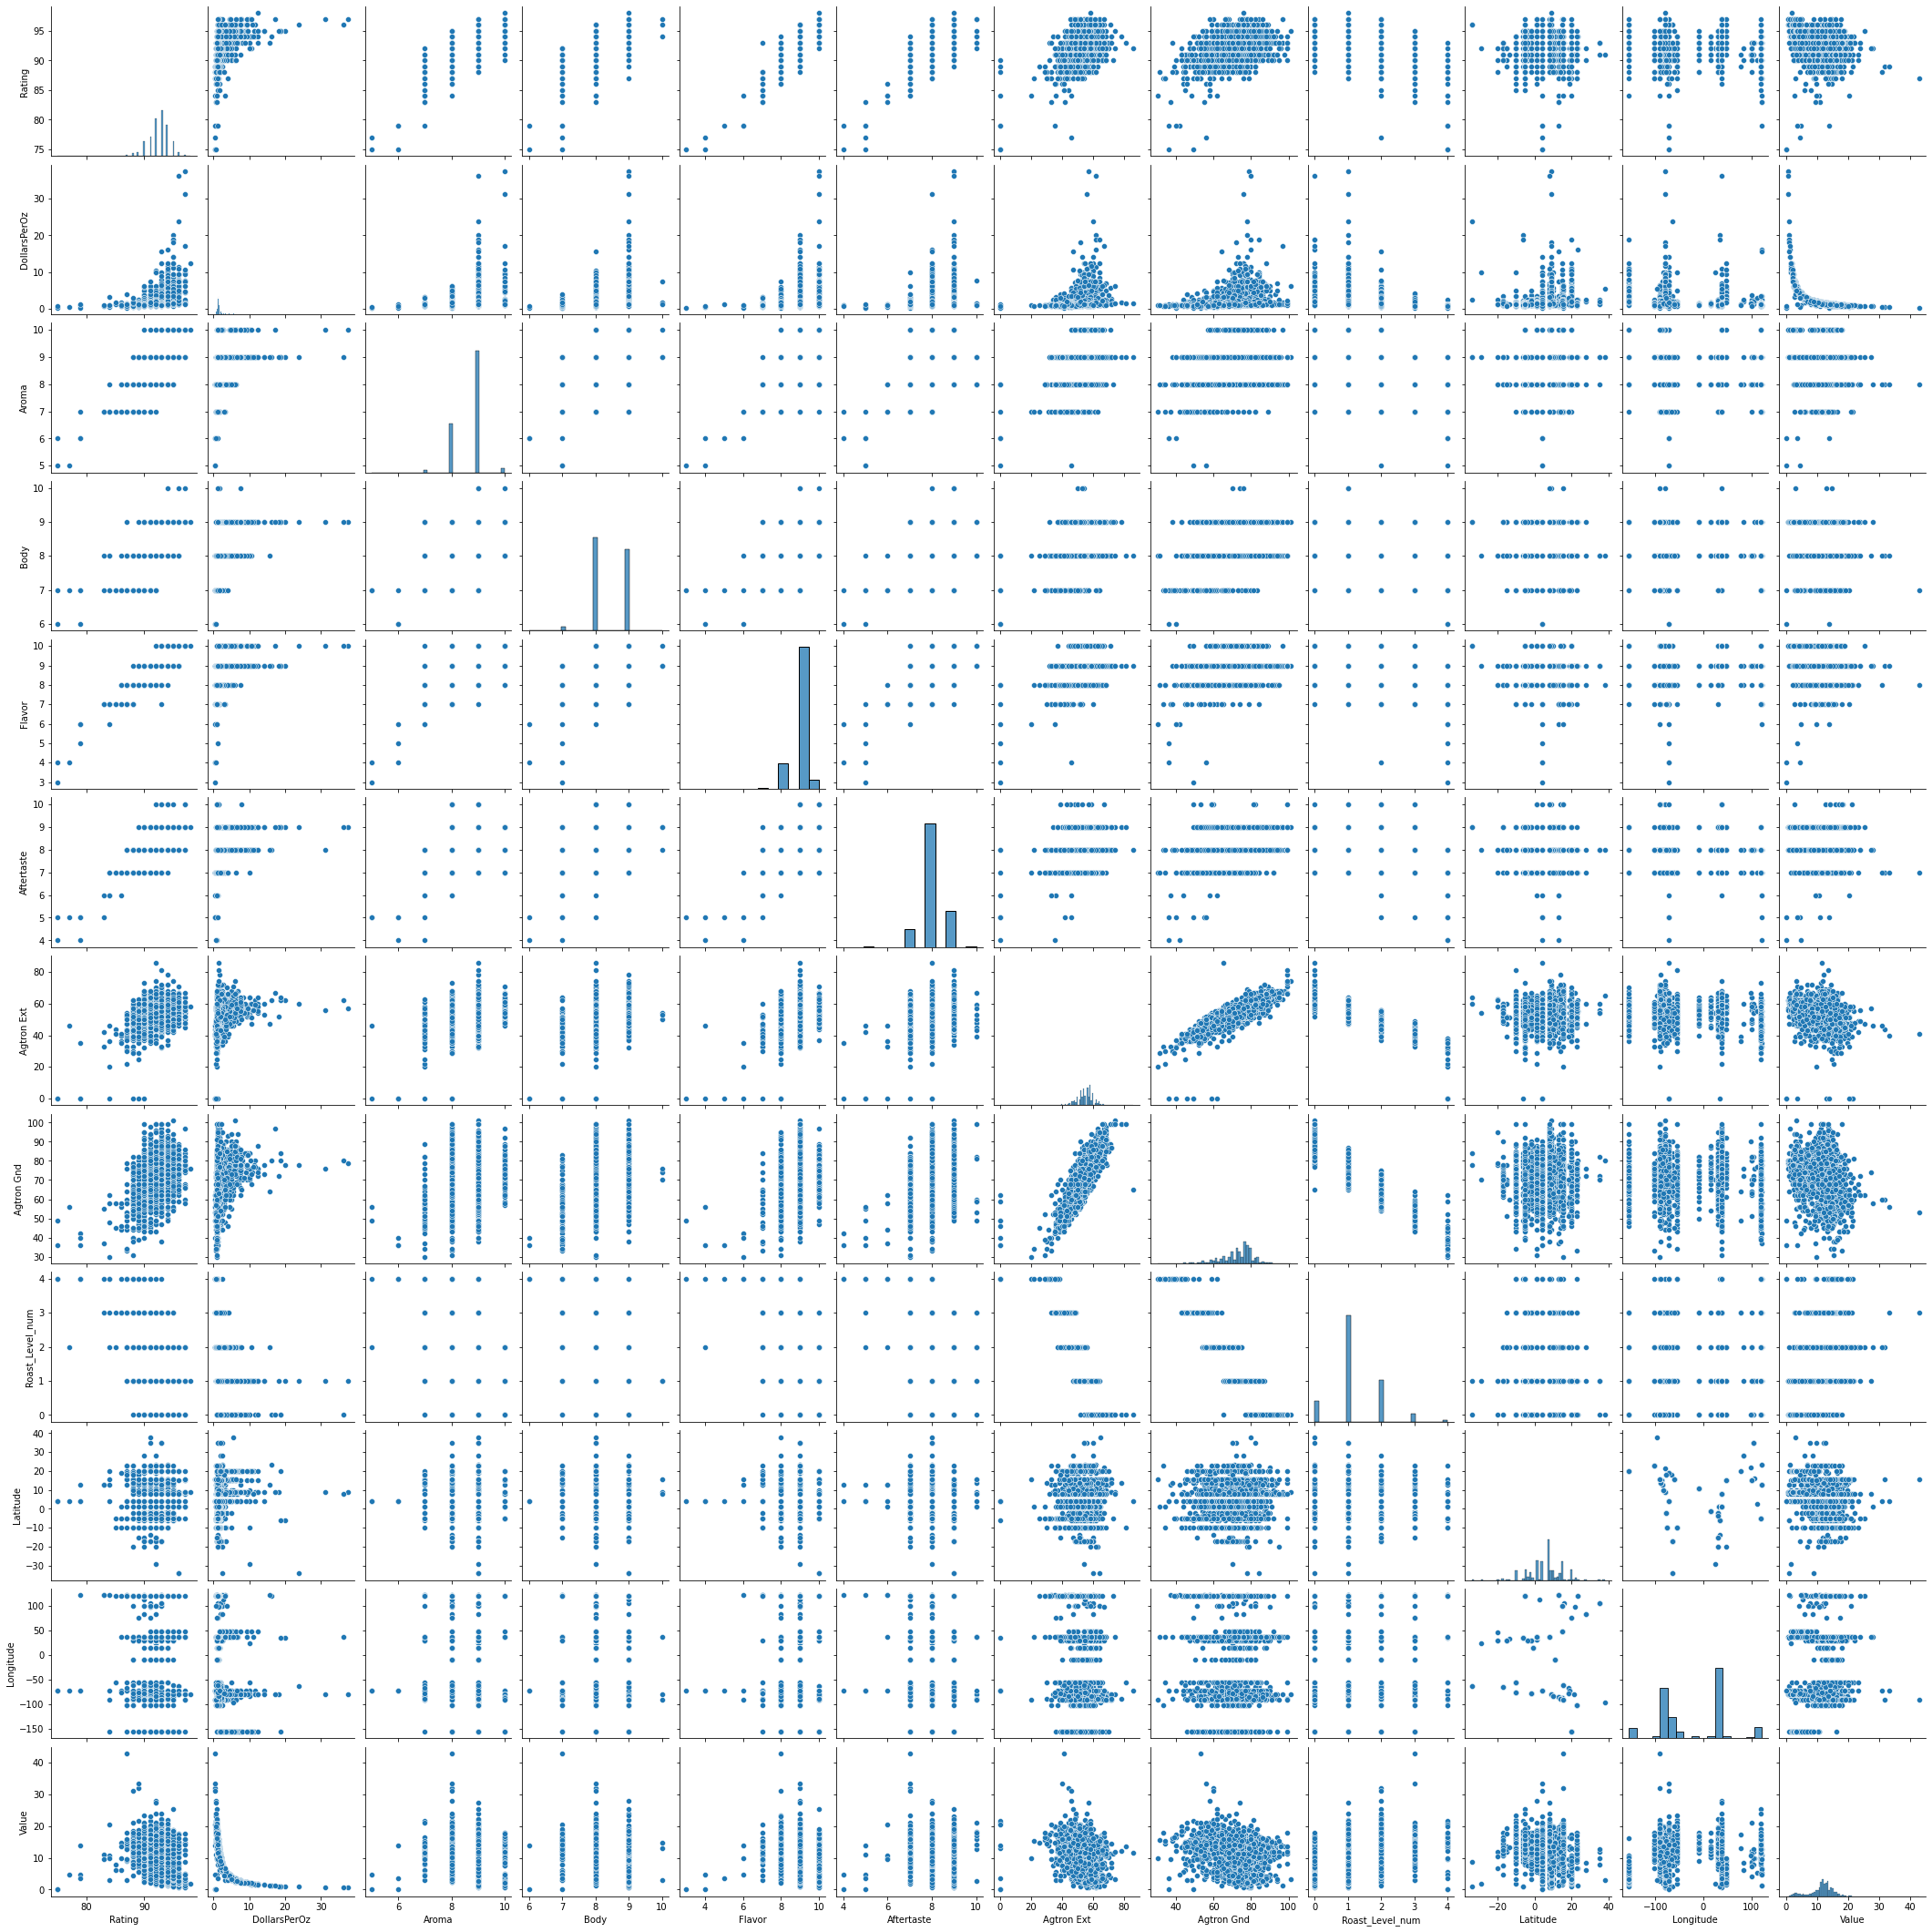

In [298]:
sns.pairplot(coffee_df)

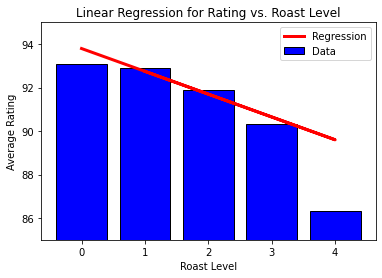

Equation: -1.05x + 93.79


In [213]:
rating_roast_ols = sm.ols(formula="Rating ~ Roast_Level_num", data=coffee_df).fit()
rating_roast_ols.summary()
params = rating_ols.params

bar_dict = {}
for i in range(5):
    roast_df = coffee_df[coffee_df["Roast_Level_num"] == i]
    bar_dict[i] = roast_df["Rating"].mean()

names = list(bar_dict.keys())
values = list(bar_dict.values())

plt.bar(range(len(bar_dict)), values, tick_label=names, color='blue', edgecolor='black')
plt.plot(coffee_df['Roast_Level_num'],rating_roast_ols.predict(),color='red',linewidth=3)
plt.ylim([85, 95])
plt.xlabel('Roast Level')
plt.ylabel('Average Rating')
plt.title("Linear Regression for Rating vs. Roast Level")
plt.legend(["Regression", "Data"])
plt.show()
params[0]
params[1]
print("Equation: " + str(round(params[1], 2)) + "x + " + str(round(params[0], 2)))

Equation: 1.67 ln(x) + 91.67


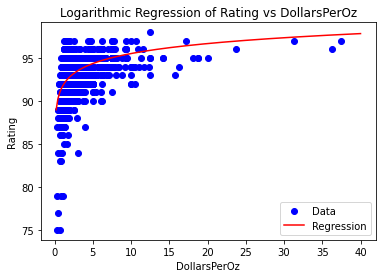

In [107]:
# Exploring Rating and DollarsPerOz
quad_model = np.poly1d(np.polyfit(np.log(coffee_df["DollarsPerOz"]), coffee_df["Rating"], 1))
plt.scatter(coffee_df["DollarsPerOz"], coffee_df["Rating"], color='blue');
x = np.linspace(-5, 40, 200)
plt.plot(x, quad_model(np.log(x)), 'r');
plt.title("Logarithmic Regression of Rating vs DollarsPerOz")
plt.xlabel("DollarsPerOz")
plt.ylabel("Rating")
plt.legend(["Data", "Regression"])
print("Equation: " + str(round(quad_model[1], 2)) + " ln(x) + " + str(round(quad_model[0], 2)))

In [50]:
# Analyzing country-by-country
ethiopia_df = coffee_df[coffee_df["Coffee Origin"] == "Ethiopia"]
ethiopia_df

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,DollarsPerOz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num,Latitude,Longitude,Value
1,SkyTop Coffee,Ethiopia Anaerobic Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,58,80,1,8.0,38.0,11.377246
2,Jaunt Coffee Roasters,Ethiopia Bensa Asefa Qonqana,94,California,Ethiopia,Light,$26.00/12 ounces,2.17,March2022,9,9,9,8,64,86,0,8.0,38.0,8.755760
3,Magnolia Coffee,Ethiopia Durato Bombe,94,North Carolina,Ethiopia,Medium-Light,$19.00/12 ounces,1.58,March2022,9,9,9,8,58,78,1,8.0,38.0,12.025316
4,SkyTop Coffee,Ethiopia Washed Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,60,78,1,8.0,38.0,11.377246
11,JBC Coffee Roasters,Twisted V.7 Espresso,93,Wisconsin,Ethiopia,Medium-Light,$17.00/12 ounces,1.42,March2022,9,8,9,8,52,74,1,8.0,38.0,12.676056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,Klatch Coffee,Ethiopian Sidamo Ardi,93,California,Ethiopia,Light,$13.95/12 oz.,1.16,May2010,9,9,9,8,59,88,0,8.0,38.0,15.517241
2866,The Coffee Bean & Tea Leaf,Mocha Java Blend,93,California,Ethiopia,Medium,$12.95/16 oz.,0.81,May2010,9,8,9,9,48,62,2,8.0,38.0,22.222222
2882,Paradise Roasters,Ethiopia Sidamo Ardi,92,Minnesota,Ethiopia,Light,$17 / 12 oz.,1.42,March2010,9,8,9,8,74,99,0,8.0,38.0,11.971831
2884,Paradise Roasters,Ethiopia Yirgacheffe,94,Minnesota,Ethiopia,Medium-Light,$13 / 12 oz.,1.08,March2010,9,8,9,8,59,82,1,8.0,38.0,17.592593


In [56]:
ethiopia_ols = sm.ols(formula="Rating ~ Roast_Level_num", data=ethiopia_df).fit()
ethiopia_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     103.6
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           1.31e-22
Time:                        00:00:48   Log-Likelihood:                -1058.9
No. Observations:                 625   AIC:                             2122.
Df Residuals:                     623   BIC:                             2131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          93.7808      0.100    934.453      0.000      93.584      93.978
Roast_Level_num    -0.7702      0.076    -10.177      0.000      -0.919      -0.622
==============================================================================
Omnibus:                        3.300   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.239
Skew:                          -0.118   Prob(JB):                        0.198
Kurtosis:                       3.263   Cond. No.                         3.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

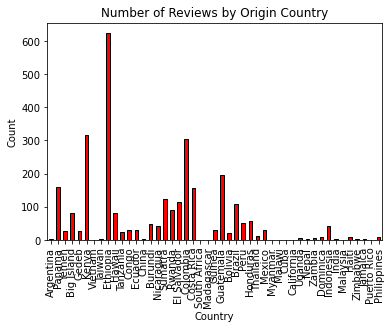

In [271]:
# Looking at the top N most common coffee origin countries
N = 50
topN_df = pd.DataFrame()

topN = coffee_df["Coffee Origin"].value_counts().nlargest(N).index.tolist()

for country in topN:
    country_df = coffee_df[coffee_df["Coffee Origin"] == country]
    country_dict = {"Country":country, "Count":len(country_df.index),"Mean Rating":country_df.Rating.mean(), "Mean Agtron Ext": country_df["Agtron Ext"].mean(), "Mean Agtron Gnd": country_df["Agtron Gnd"].mean(), "Mean Dollars/Oz":country_df["DollarsPerOz"].mean(), "Mean Value": country_df["Value"].mean()}
    topN_df = topN_df.append(country_dict, ignore_index=True)

topN_df = topN_df.sort_values(by=['Mean Rating'], ascending=False)
    
topN_df.plot.bar(y="Count", x="Country", legend=None, color='red', edgecolor='black');
plt.title("Number of Reviews by Origin Country");
plt.ylabel("Count");

In [272]:
topN_df.corr()

,Count,Mean Rating,Mean Agtron Ext,Mean Agtron Gnd,Mean Dollars/Oz,Mean Value
Count,1.000000,0.293716,0.032844,0.050635,-0.127641,0.199435
Mean Rating,0.293716,1.000000,0.523600,0.527762,0.408332,-0.093639
Mean Agtron Ext,0.032844,0.523600,1.000000,0.918194,0.306342,-0.278017
Mean Agtron Gnd,0.050635,0.527762,0.918194,1.000000,0.241444,-0.237993
Mean Dollars/Oz,-0.127641,0.408332,0.306342,0.241444,1.000000,-0.767428
Mean Value,0.199435,-0.093639,-0.278017,-0.237993,-0.767428,1.000000


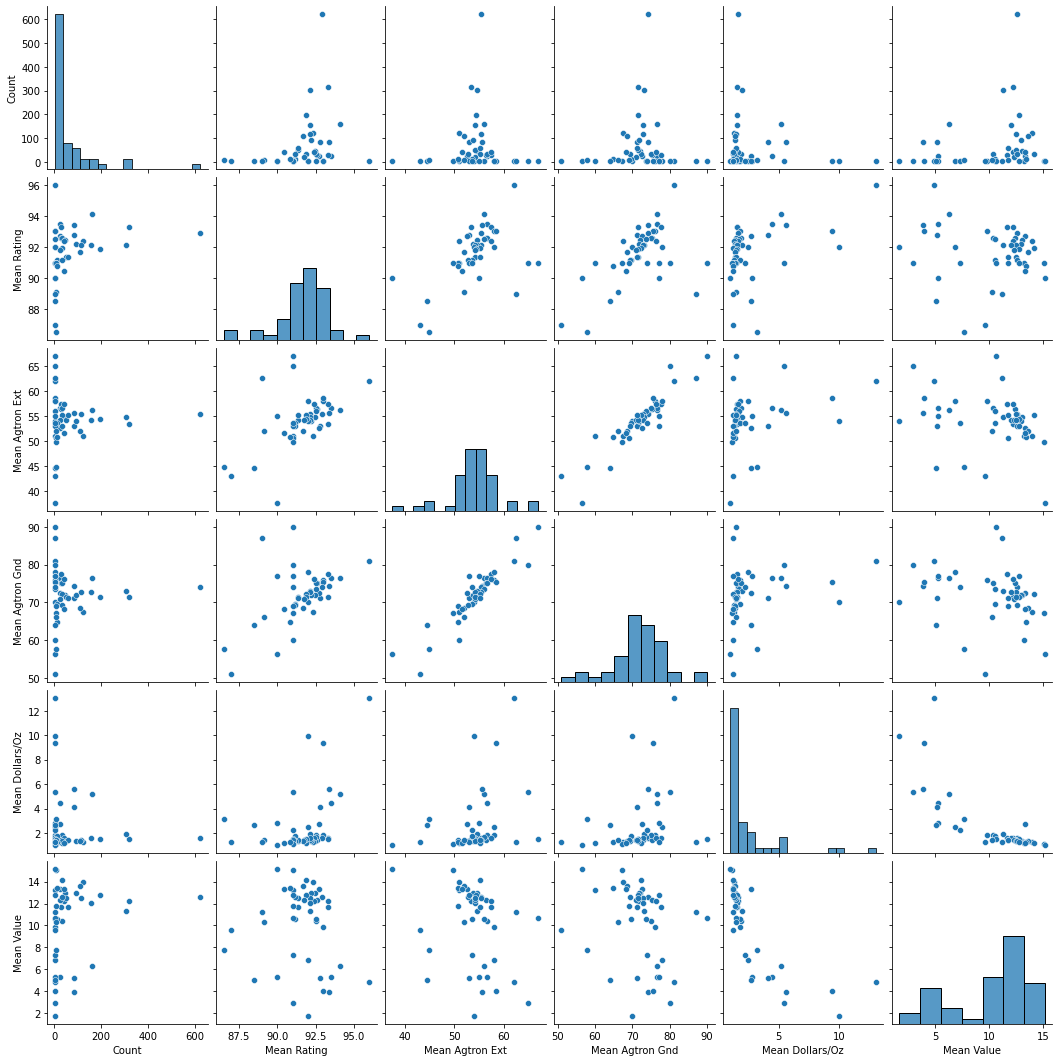

In [273]:
sns.pairplot(topN_df)

<AxesSubplot:>

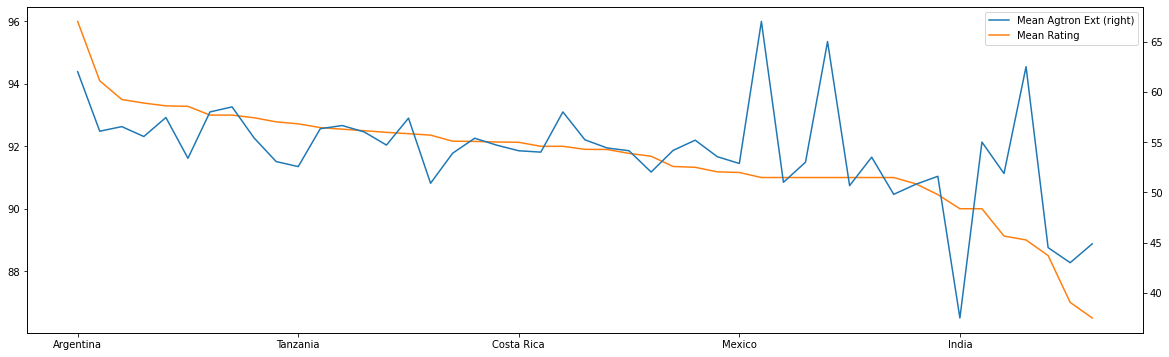

In [269]:
# Attempting to find/visualize a connection between agtron values and rating
fig, ax = plt.subplots(figsize=(20,6))

plot_df = pd.DataFrame({"Mean Agtron Ext": topN_df["Mean Agtron Ext"].values.tolist(), "Mean Rating": topN_df["Mean Rating"].values.tolist()}, index=topN_df["Country"].values.tolist())
plot_df.plot(kind='line',secondary_y="Mean Agtron Ext", rot=0, ax=ax)


In [225]:
# Case study on top X rated coffees?
N = 10
topN = coffee_df.nlargest(N, "Rating")

top_coffees = coffee_df.sort_values(by="Rating",ascending=False)

top_coffees
topN

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,DollarsPerOz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num,Latitude,Longitude,Value
440,Equator Coffees,Finca Sophia Gesha Washed,98,California,Panama,Medium-Light,$50.00/4 ounces,12.50,November2020,10,9,10,9,58,76,1,9.0,-80.0,1.840000
17,Paradise Roasters,Colombia Finca El Paraiso Geisha Letty,97,Minnesota,Colombia,Light,$40.00/4 ounces,10.00,February2022,10,9,10,9,64,84,0,4.0,-72.0,2.200000
111,Paradise Roasters,Mama Cata Mokkita,97,Minnesota,Panama,Medium-Light,$150.00/4 ounces,37.50,November2021,10,9,10,9,57,79,1,9.0,-80.0,0.586667
206,Barrington Coffee Roasting,Testi Ayla Double Ethiopia,97,Massachusetts,Ethiopia,Light,$54.95/12 ounces,4.58,August2021,9,9,10,9,64,86,0,8.0,38.0,4.803493
445,JBC Coffee Roasters,Ardent Ethiopia Natural,97,Wisconsin,Ethiopia,Medium-Light,$35.00/8 ounces,4.38,November2020,10,9,10,9,57,77,1,8.0,38.0,5.022831
747,Dragonfly Coffee Roasters,Washed Geisha Hacienda La Esmeralda Jaramillo ...,97,Colorado,Panama,Medium-Light,$125.00/4 ounces; limited availability,31.25,November2019,10,9,10,8,56,76,1,9.0,-80.0,0.704000
801,JBC Coffee Roasters,Rukera Kenya,97,Wisconsin,Kenya,Medium-Light,$21.20/12 ounces,1.77,July2019,10,9,10,9,54,78,1,1.0,38.0,12.429379
802,JBC Coffee Roasters,Rukera Espresso,97,Wisconsin,Kenya,Medium-Light,$21.20/12 ounces,1.77,July2019,10,9,10,9,54,78,1,1.0,38.0,12.429379
874,Dragonfly Coffee Roasters,Kenya Karindundu AA Small Lot Reserve,97,Colorado,Kenya,Medium-Light,$18.00/12 ounces,1.50,February2019,10,9,10,9,54,78,1,1.0,38.0,14.666667
902,Bird Rock Coffee Roasters,Panama Ninety Plus Perci Lot 50,97,California,Panama,Medium-Light,$60.00/8 ounces,7.50,January2019,10,10,10,9,50,74,1,9.0,-80.0,2.933333


### Global Analysis

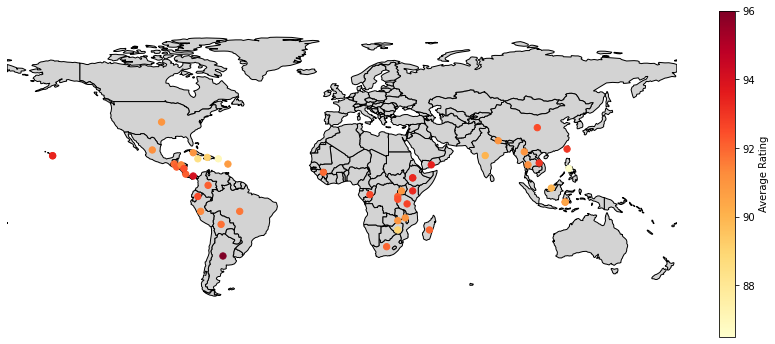

In [54]:
# World map plot

# Collecting all coffee origin countries and putting characteristics into a dataframe
origins_df = pd.DataFrame()

countries = coffee_df["Coffee Origin"].value_counts().index.tolist()

for country in countries:
    country_df = coffee_df[coffee_df["Coffee Origin"] == country]
    lat = latlong_df[latlong_df.Country == country].Latitude.values[0]
    long = latlong_df[latlong_df.Country == country].Longitude.values[0]

    country_dict = {"Country":country, "Count":len(country_df.index),"Average Rating":country_df.Rating.mean(), "Average Agtron Ext": country_df["Agtron Ext"].mean(), "Average Dollars/Oz":country_df["DollarsPerOz"].mean(), "Mean Value": country_df["Value"].mean(), "Latitude": lat, "Longitude": long}
    origins_df = origins_df.append(country_dict, ignore_index=True)

fig, ax = plt.subplots(figsize=(15,6))
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries = countries[countries.name != "Antarctica"]

geoplot.polyplot(countries,facecolor='lightgray', ax=ax)

# Filter out countries that have less than 5 reviews from there
origins_df_filt = origins_df[origins_df["Count"] >= 10]

origins_df.plot(x="Longitude", y="Latitude", s=40,kind="scatter", c="Average Rating", ax=ax, cmap="YlOrRd");



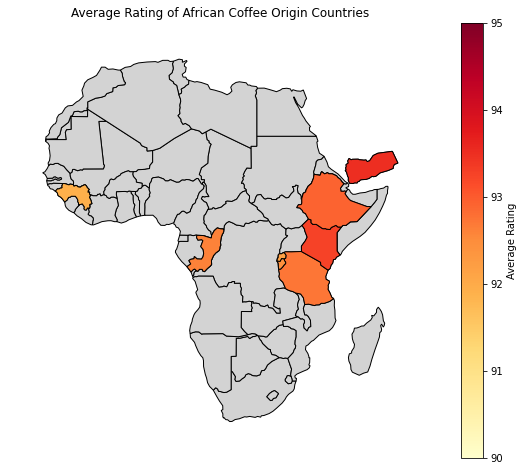

In [55]:
# Africa plot 
fig, ax = plt.subplots(figsize=(10,8))

africa = countries.query('continent == "Africa"')
yemen = countries[countries.name == "Yemen"]
africa = africa.append(yemen)

africa_df = pd.DataFrame()
rating_dict_africa = {}
        
for country in africa.name:
    if country.lower() in list(map(lambda s: s.lower().strip(), origins_df_filt["Country"].values.tolist())):
        country_df = origins_df_filt[origins_df_filt["Country"] == country]
        rating_dict_africa[country] = country_df["Average Rating"].values[0]    
        africa_df = africa_df.append(country_df)
        
review_countries_africa = africa[africa.name.isin(origins_df_filt["Country"].values.tolist())]

norm = plt.Normalize(vmin=90, vmax=95)
cmap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

geoplot.choropleth(review_countries_africa,hue=rating_dict_africa.values(), cmap=cmap.cmap,norm=norm, ax=ax);
geoplot.polyplot(africa,facecolor='lightgray',ax=ax);
cbar = ax.figure.colorbar(cmap)
cbar.set_label("Average Rating")
ax.title.set_text("Average Rating of African Coffee Origin Countries")

#africa_df.plot(x="Longitude", y="Latitude", kind="scatter", c="g", ax=ax);

In [56]:
africa_df

,Country,Count,Average Rating,Average Agtron Ext,Average Dollars/Oz,Mean Value,Latitude,Longitude
23,Tanzania,25,92.720000,52.560000,2.724800,13.306686,-6.0,35.0
1,Kenya,317,93.280757,53.388013,1.560410,12.209087,1.0,38.0
18,Guinea,31,91.903226,55.225806,1.212258,14.130785,11.0,-10.0
20,Congo,30,92.600000,56.333333,1.448667,12.357103,-1.0,15.0
14,Burundi,47,92.446809,54.702128,1.393830,13.004541,-3.5,30.0
0,Ethiopia,624,92.915064,55.408654,1.604952,12.617313,8.0,38.0
9,Rwanda,91,92.164835,53.890110,1.369560,12.951588,-2.0,30.0
22,Yemen,26,93.500000,56.538462,4.488462,5.308887,15.0,48.0


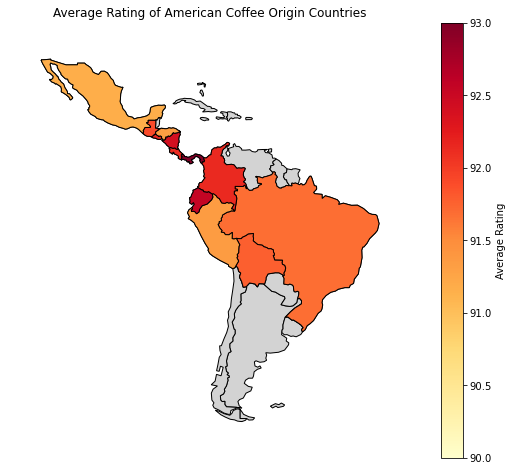

In [60]:
# North and South America plot
fig, ax = plt.subplots(figsize=(10,8))

SA = countries.query('continent == "South America"')
NA = countries.query('continent == "North America"')
NA = NA[countries.name != "United States of America"]
NA = NA[countries.name != "Canada"]
NA = NA[countries.name != "Greenland"]

america = NA.append(SA)

america_df = pd.DataFrame()
rating_dict_america = {}

for country in america.name:
    if country.lower() in list(map(lambda s: s.lower().strip(), origins_df_filt["Country"].values.tolist())):
        country_df = origins_df_filt[origins_df_filt["Country"] == country]
        rating_dict_america[country] = country_df["Average Rating"].values[0]    
        america_df = america_df.append(country_df)
        
review_countries_america = america[america.name.isin(origins_df_filt["Country"].values.tolist())]

norm = plt.Normalize(vmin=90, vmax=93)
cmap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

geoplot.choropleth(review_countries_america,hue=rating_dict_america.values(), cmap=cmap.cmap,norm=norm, ax=ax);
geoplot.polyplot(america,facecolor='lightgray',
ax=ax);
cbar = ax.figure.colorbar(cmap)
cbar.set_label("Average Rating")
ax.title.set_text("Average Rating of American Coffee Origin Countries")

#america_df.plot(x="Longitude", y="Latitude", kind="scatter", c="g", ax=ax);

In [61]:
america_df

,Country,Count,Average Rating,Average Agtron Ext,Average Dollars/Oz,Mean Value,Latitude,Longitude
17,Mexico,31,91.161290,52.870968,1.335806,12.629316,23.00,-102.00
4,Panama,160,94.100000,56.081250,5.211563,6.318467,9.00,-80.00
5,Costa Rica,156,92.128205,54.134615,1.583077,12.010253,10.00,-84.00
15,Nicaragua,42,92.404762,57.380952,1.635000,12.189455,13.00,-85.00
12,Honduras,58,91.327586,55.189655,1.441552,11.710100,15.00,-86.50
7,El Salvador,115,92.156522,55.382609,1.456957,12.491202,13.83,-88.92
3,Guatemala,197,91.898477,54.416244,1.533452,12.779478,15.50,-90.25
8,Brazil,110,91.681818,52.018182,1.366182,13.557241,-10.00,-55.00
24,Bolivia,22,91.772727,54.136364,1.474545,12.330557,-17.00,-65.00
13,Peru,51,91.352941,54.176471,1.382549,12.514694,-10.00,-76.00


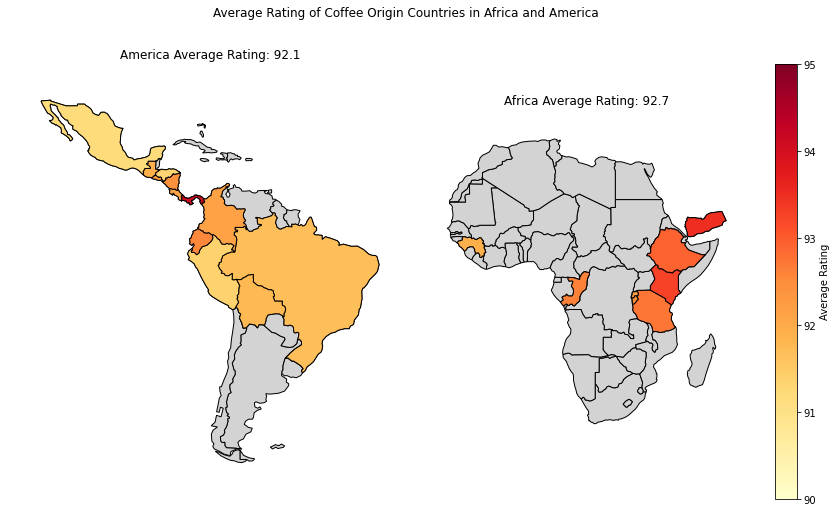

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(15,8))
plt.subplots_adjust(wspace=0, hspace=0)

norm = plt.Normalize(vmin=90, vmax=95)
cmap = plt.cm.ScalarMappable(norm=norm, cmap='YlOrRd')

geoplot.choropleth(review_countries_america,hue=rating_dict_america.values(), cmap=cmap.cmap,norm=norm, ax=axs[0]);
geoplot.polyplot(america,facecolor='lightgray',
ax=axs[0]);
axs[0].set_title("America Average Rating: " + str(round(america_df["Average Rating"].mean(), 1)))


geoplot.choropleth(review_countries_africa,hue=rating_dict_africa.values(), cmap=cmap.cmap,norm=norm, ax=axs[1]);
geoplot.polyplot(africa,facecolor='lightgray',ax=axs[1]);
axs[1].set_title("Africa Average Rating: " + str(round(africa_df["Average Rating"].mean(), 1)))

cbar = fig.colorbar(cmap)
cbar.set_label("Average Rating")
fig.suptitle("Average Rating of Coffee Origin Countries in Africa and America");

### Classification

In [241]:
# Classification models to predict coffee origin country, roaster, and rating from roast level and price of a coffee

# Regression model for predicting rating
rating_ols = sm.ols(formula="Rating ~ Roast_Level_num + DollarsPerOz", data=coffee_df).fit()
params = rating_ols.params
intercept = params[0]
roast_slope = params[1]
price_slope = params[2]
params

Intercept          93.150997
Roast_Level_num    -0.930718
DollarsPerOz        0.247829
dtype: float64

In [242]:
# Classification model for predicting coffee origin country
predicts = coffee_df[["Roast_Level_num", "DollarsPerOz"]].values
origins = coffee_df["Coffee Origin"].values
# best_accuracy = 0
# best_C = 0
# Cs = np.linspace(0.1,200,5)
# accuracies = []
# predicts_train, predicts_test, origins_train, origins_test = train_test_split(predicts, origins, random_state=2, test_size=0.5, train_size=0.5)

# # Find the best C value for the model
# for i,C in enumerate(Cs): 
#     svm_origins = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     svm_origins.fit(predicts_train, origins_train)
#     origins_pred = svm_origins.predict(predicts_test)
#     scores = cross_val_score(estimator = svm_origins, X = predicts_test, y = origins_pred, cv=5, scoring='accuracy')    
#     accuracy = np.mean(scores)
#     accuracies.append(accuracy)
#     if accuracy > best_accuracy:
#         best_C = C
#         best_accuracy = accuracy

# plt.plot(Cs, np.multiply(accuracies, 100))
# plt.title("Coffee Origin Country Classification using SVM");
# plt.xlabel("C");
# plt.ylabel("Accuracy");

best_C = 50
svm_origins = svm.SVC(kernel='rbf', C = best_C,gamma='scale');
svm_origins.fit(predicts, origins);

In [243]:
# Classification model for predicting roaster
predicts = coffee_df[["Roast_Level_num", "DollarsPerOz"]].values
roasters = coffee_df["Roaster"].values
# best_accuracy = 0
# best_C = 0
# Cs = np.linspace(0.1,200,5)
# accuracies = []
# predicts_train, predicts_test, roasters_train, roasters_test = train_test_split(predicts, roasters, random_state=2, test_size=0.5, train_size=0.5)

# # Find the best C value for the model
# for i,C in enumerate(Cs): 
#     svm_roasters = svm.SVC(kernel='rbf', C = C,gamma='scale')
#     svm_roasters.fit(predicts_train, roasters_train)
#     roasters_pred = svm_roasters.predict(predicts_test)
#     scores = cross_val_score(estimator = svm_roasters, X = predicts_test, y = roasters_pred, cv=5, scoring='accuracy')    
#     accuracy = np.mean(scores)
#     accuracies.append(accuracy)
#     if accuracy > best_accuracy:
#         best_C = C
#         best_accuracy = accuracy

# plt.plot(Cs, np.multiply(accuracies, 100))
# plt.title("Roaster Classification using SVM");
# plt.xlabel("C");
# plt.ylabel("Accuracy");

best_C = 0.1
svm_roasters = svm.SVC(kernel='rbf', C = best_C,gamma='scale');
svm_roasters.fit(predicts, roasters);

In [244]:
# Function to predict roaster, origin country, and rating from roast level and price
def predict(roast_level, price):
    priceperoz = price / 8 # assume an 8 oz. drink
        
    inputs = np.array([roast_level, priceperoz]).reshape(1, -1)
    roaster = svm_roasters.predict(inputs)[0]
    origin = svm_origins.predict(inputs)[0]
    rating = intercept + roast_slope * roast_level + price_slope * priceperoz
    rating = svm_ratings.predict(inputs)[0]
    return [roaster, origin, rating]

In [ ]:
# Basic Program
continue_bool = True

roast_level = input("Enter Desired Roast Level (0 = Light, 1 = Medium-Light, 2 = Medium, 3 = Dark, 4 = Very Dark): ")

try:
    roast_level = int(roast_level)

    if roast_level < 0 or roast_level > 4:
        raise ValueError()
        
except ValueError:
    print("Error: input for roast level must be an integer between 0 and 4")
    continue_bool = False

if continue_bool:
    price = input("Enter Desired Price in Dollars for an 8 oz. Drink: ")
    try:
        price = float(price)

        if price <= 0:
            raise ValueError()
    except ValueError:
        print("Error: price must be greater than $0")
        continue_bool = False
        
    if continue_bool:
        [roaster, origin, rating] = predict(roast_level, price)
        print()
        print(f"Predicted Country of Origin: {origin}")
        print(f"Predicted Roaster: {roaster}")
        print(f"Predicted Rating: {round(rating, 2)}")

### Coffee Predictor Program

In [299]:
# Tkinter Program

from tkinter import *
from tkinter import messagebox
import tkinter as tk

def getPredictions ():
    continue_bool = True
    try:
        roast_level = int(input1.get())

        if roast_level < 0 or roast_level > 4:
            raise ValueError()

    except ValueError:
        continue_bool = False
        messagebox.showerror('Value Error', "Error: input for roast level must be an integer between 0 and 4")
    if continue_bool:
        try:
            price = float(input2.get())
            if price <= 0:
                raise ValueError()
        except ValueError:
            messagebox.showerror('Value Error', "Error: price must be greater than $0")
            continue_bool = False
        if continue_bool:
            inputs = np.array([roast_level, price]).reshape(1, -1)
            roaster = svm_roasters.predict(inputs)[0]
            origin = svm_origins.predict(inputs)[0]
            rating = intercept + roast_slope * roast_level + price_slope * price
            if rating > 100:
                rating = 100
            
            result4 = tk.Label(root, text=origin, font=('helvetica', 11))
            result4.grid(row =4, column=0, pady = 2, padx = 1)
            result5 = tk.Label(root, text=roaster, font=('helvetica', 11))
            result5.grid(row =4, column=1, pady = 2, padx = 1)
            result6 = tk.Label(root, text=str(round(rating,2)), font=('helvetica', 11))
            result6.grid(row =4, column=2, pady = 2, padx = 1)            
            
root= tk.Tk()
root.title("Coffee Predictor")
root.geometry("600x200")
root.eval('tk::PlaceWindow . center')


label1 = tk.Label(root, text="Roast Level (0, 1, 2, 3, 4)",font=('helvetica', 10, 'bold'))
label1.grid(row =0, column=0, pady = 1, padx = 5)
label2 = tk.Label(root, text="Price Per Oz (> 0)",font=('helvetica', 10, 'bold'))
label2.grid(row=0, column=2, pady = 1, padx = 5)

input1 = tk.Entry(root)
input1.grid(row=1, column=0, pady = 5, padx = 5)
input2 = tk.Entry(root)
input2.grid(row=1, column=2, pady = 5, padx = 5)
button = tk.Button(text='Predict', command=getPredictions,  bg='red', fg='white', font=('helvetica', 9, 'bold'))
button.grid(row=2, column=1, pady = 20)

result1 = tk.Label(root, text="Origin Country",font=('helvetica', 10, 'bold'))
result1.grid(row =3, column=0, pady = 1, padx = 1)
result2 = tk.Label(root, text="Roaster", font=('helvetica', 10, 'bold'))
result2.grid(row =3, column=1, pady = 1, padx = 1)
result3 = tk.Label(root, text="Rating", font=('helvetica', 10, 'bold'))
result3.grid(row =3, column=2, pady = 1, padx = 1)

root.grid_columnconfigure((0, 2), weight=1)

root.mainloop()

## Results

A summary of the results of the project

## Evaluation

What are the metrics used to evaluate how successful your project is?

## Project Summary

Answer specific questions below using only 1-2 sentences:

What is an overview of your project?

What are your project objectives?

What are your technical contributions?

What are the main results?

How are the results evaluated?

What are the future directions?